This project is to build the deep learning model based on the histopathologic image to determine whether the patients have cancer or not.


The training set include 220,025 files, and the testing set include 57458 images. The image size is 96X96 pixes, however, only the center region 32X32 pixes are labeled. 

In [8]:
#Load necessary package
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import numpy as np
import os
from PIL import Image
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential

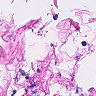

In [10]:
#Load a image
train_dir = r'D:\ML\DeepLearning\Week3\train'
image_file='0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif'
image_path = os.path.join(train_dir, image_file)
# Load the image
image = Image.open(image_path)
# Display the image
display(image)

In [2]:
#Load label csv files
labels_df=pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
labels_dict = labels_df.set_index('id').to_dict()['label']
train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'
# Crop the image to 32*32
def crop_center(image,crop_size=32):
    width,height=image.size
    left=(width-crop_size)//2
    top=(height-crop_size)//2
    right=left+crop_size
    bottom=top+crop_size
    return image.crop((left, top, right, bottom))
    
#Convert the image to array
def load_and_preprocess_images(folder, labels_dic=None, crop=True):
    images, labels = [], []
    for file in os.listdir(folder):
        img_id = os.path.splitext(file)[0]  # Extract the image ID as a string
        img_path = os.path.join(folder, file)
        image = Image.open(img_path)
        
        # Crop to the center if needed
        if crop:
            image = crop_center(image)
        
        # Normalize image and append
        image_array = np.array(image) / 255.0
        images.append(image_array)
        
        # Append label if in training set
        if labels_dic:
            labels.append(labels_dic[img_id])  # Use img_id as a string key
    
    return np.array(images), np.array(labels) if labels_dic else None

X_train, y_train = load_and_preprocess_images(train_dir, labels_dict)
X_test, _ = load_and_preprocess_images(test_dir)
print(f"Number of images loaded: {len(X_test)}")

# Build the model
model = Sequential([
    Input(shape=(32, 32, 3)),  
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

#Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Predict the test dataset
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)
test_image_files = [f for f in os.listdir(test_dir) if f.endswith('.tif')]  # Ensure you use the correct directory path

submission_df = pd.DataFrame({
    'id': [os.path.splitext(file)[0] for file in test_image_files],  # Extracting image ID without the extension
    'label': predicted_labels.flatten()  # Flattening predictions if necessary
})

submission_df.to_csv('/kaggle/working/submission.csv', index=False)

Number of images loaded: 57458


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,561 (1.20 MB)

 Trainable params: 314,561 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1733434932.226999      91 service.cc:145] XLA service 0x7d362c003ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733434932.227054      91 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  73/5501 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5776 - loss: 0.6717 

I0000 00:00:1733434935.528880      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.7447 - loss: 0.5291 - val_accuracy: 0.7787 - val_loss: 0.4799
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7862 - loss: 0.4714 - val_accuracy: 0.8008 - val_loss: 0.4436
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7983 - loss: 0.4513 - val_accuracy: 0.7729 - val_loss: 0.4791
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8024 - loss: 0.4411 - val_accuracy: 0.8104 - val_loss: 0.4275
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8083 - loss: 0.4336 - val_accuracy: 0.7828 - val_loss: 0.4682
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8090 - loss: 0.4291 - val_accuracy: 0.8096 - val_loss: 0.4286
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8146 - loss: 0.4201 - val_accuracy: 0.8129 - val_loss: 0.4236
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8166 - loss: 0.4167 - val